In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os
import cv2

In [ ]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    elif obj.find('name').text == "without_mask":
        return 3
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [ ]:
!mkdir face-mask-detection
!unzip drive/MyDrive/facemaskdetection.zip -d face-mask-detection

Archive:  drive/MyDrive/facemaskdetection.zip
  inflating: face-mask-detection/annotations/maksssksksss0.xml  
  inflating: face-mask-detection/annotations/maksssksksss1.xml  
  inflating: face-mask-detection/annotations/maksssksksss10.xml  
  inflating: face-mask-detection/annotations/maksssksksss100.xml  
  inflating: face-mask-detection/annotations/maksssksksss101.xml  
  inflating: face-mask-detection/annotations/maksssksksss102.xml  
  inflating: face-mask-detection/annotations/maksssksksss103.xml  
  inflating: face-mask-detection/annotations/maksssksksss104.xml  
  inflating: face-mask-detection/annotations/maksssksksss105.xml  
  inflating: face-mask-detection/annotations/maksssksksss106.xml  
  inflating: face-mask-detection/annotations/maksssksksss107.xml  
  inflating: face-mask-detection/annotations/maksssksksss108.xml  
  inflating: face-mask-detection/annotations/maksssksksss109.xml  
  inflating: face-mask-detection/annotations/maksssksksss11.xml  
  inflating: face-mask

In [ ]:

imgs = list(sorted(os.listdir("face-mask-detection/images/")))
labels = list(sorted(os.listdir("face-mask-detection/annotations/")))

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("face-mask-detection/images/")))
#         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("face-mask-detection/images/", file_image)
        label_path = os.path.join("face-mask-detection/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [ ]:
torch.cuda.is_available()

True

# Model

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 174MB/s]


Next block is to use previously trained model(to continue training for example)

In [ ]:
model.load_state_dict(torch.load('drive/MyDrive/model.pt'))

<All keys matched successfully>

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([3, 1, 3], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 3], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 2], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

# Training

In [ ]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
num_epochs = 25

    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)

tensor(21.3075, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.5356, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: ignored

In [ ]:
num_epochs = 5

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.004,
                                momentum=0.1, weight_decay=0.0004)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)

tensor(5.6214, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.4434, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.3414, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.3813, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2399, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

saving model

In [ ]:
torch.save(model.state_dict(),'drive/MyDrive/model.pt')

# Loading model

In [ ]:
model2 = get_model_instance_segmentation(4)

In [ ]:
model2.load_state_dict(torch.load('drive/MyDrive/model.pt'))
model2.eval()
model2.cpu()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

plotting image

In [ ]:
for imgs, annotations in data_loader:
        imgs = list(img.cpu() for img in imgs)
        annotations = [{k: v.cpu() for k, v in t.items()} for t in annotations]
        break

In [ ]:

pred = model2(imgs)


In [ ]:
def plot_image(img_tensor, annotation, block=True):

  fig,ax = plt.subplots(1)
  img = img_tensor.cpu().data
  # Display the image
  ax.imshow( np.array( img.permute(1, 2, 0) ) )

  for box, label in zip( annotation["boxes"], annotation["labels"] ):
    print("label",label)
    print("box",box)
    xmin, ymin, xmax, ymax = box.detach()
    # Create a Rectangle patch
    if label==1:
      rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
    elif label==2:
      rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')
    else:
      rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes 
    ax.add_patch(rect)
    ax.axis("off")
  plt.show(block=block)

Prediction
label tensor(1)
box tensor([226.1417,  37.2894, 259.4782,  75.2013], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([319.6107,  33.7235, 352.9624,  70.4455], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([143.5873,  75.6177, 173.9407, 112.4921], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([21.6067, 72.7862, 42.5587, 92.9598], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([298.7642,  59.5687, 313.6095,  79.9628], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([ 82.9225,  56.6570, 111.4812,  89.2506], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([195.7428,  66.1910, 216.3360,  94.1173], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([368.3468,  71.0397, 390.9200,  94.6271], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([368.2429,  69.9273, 393.8059,  91.5316], grad_fn=<UnbindBackward0>)
label tensor(2)
box tensor([368.4744,  70.6625, 391.4736,  91.7754], grad_fn=<UnbindBackward0>)


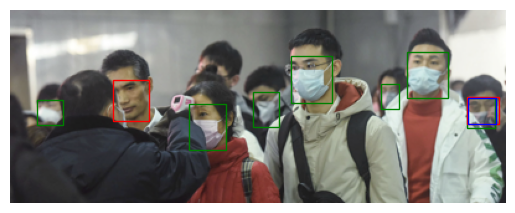

Target
label tensor(1)
box tensor([321.,  34., 354.,  69.])
label tensor(1)
box tensor([224.,  38., 261.,  73.])
label tensor(1)
box tensor([299.,  58., 315.,  81.])
label tensor(1)
box tensor([143.,  74., 174., 115.])
label tensor(1)
box tensor([74., 69., 95., 99.])
label tensor(1)
box tensor([191.,  67., 221.,  93.])
label tensor(1)
box tensor([21., 73., 44., 93.])
label tensor(1)
box tensor([369.,  70., 398.,  99.])
label tensor(3)
box tensor([ 83.,  56., 111.,  89.])


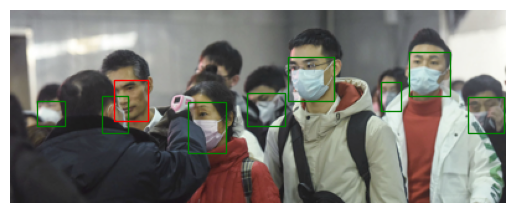

In [ ]:
idxi = 1
print("Prediction")
plot_image(imgs[idxi], pred[idxi])
print("Target")
plot_image(imgs[idxi], annotations[idxi])

In [ ]:
!wget https://www.japantimes.co.jp/wp-content/uploads/2022/06/np_file_162496.jpeg 
!wget https://s.abcnews.com/images/US/face-masks-ap-jef-200505_hpMain_16x9_992.jpg
!wget https://images.moneycontrol.com/static-mcnews/2020/12/covid-19-coronavirus-new-covid-strain-in-uk-mumbai-airport-770x433.jpg?impolicy=website&width=770&height=431
!wget https://media-cldnry.s-nbcnews.com/image/upload/t_fit-760w,f_auto,q_auto:best/newscms/2022_07/3535044/220214-people-masks-california-ew-613p.jpg
!wget https://notesfrompoland.com/wp-content/uploads/2020/08/50165738316_c3682dea2d_k-1080x675.jpg

--2023-05-14 15:18:21--  https://www.japantimes.co.jp/wp-content/uploads/2022/06/np_file_162496.jpeg
Resolving www.japantimes.co.jp (www.japantimes.co.jp)... 52.199.50.123, 13.114.69.182
Connecting to www.japantimes.co.jp (www.japantimes.co.jp)|52.199.50.123|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn-japantimes.com/wp-content/uploads/2022/06/np_file_162496.jpeg [following]
--2023-05-14 15:18:21--  https://cdn-japantimes.com/wp-content/uploads/2022/06/np_file_162496.jpeg
Resolving cdn-japantimes.com (cdn-japantimes.com)... 104.26.0.202, 104.26.1.202, 172.67.69.89, ...
Connecting to cdn-japantimes.com (cdn-japantimes.com)|104.26.0.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218442 (213K) [image/jpeg]
Saving to: ‘np_file_162496.jpeg.7’

np_file_162496.jpeg 100%[===================>] 213.32K  --.-KB/s    in 0.03s   

2023-05-14 15:18:22 (7.07 MB/s) - ‘np_file_162496.jpeg.7’ saved [218442/218442]



In [ ]:
def load_test_image( filename):
  return data_transform(cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB))

batches = []
batches.append([load_test_image('np_file_162496.jpeg')])
batches.append([load_test_image('face-masks-ap-jef-200505_hpMain_16x9_992.jpg')])
batches.append([load_test_image('220214-people-masks-california-ew-613p.jpg')])
batches.append([load_test_image('covid-19-coronavirus-new-covid-strain-in-uk-mumbai-airport-770x433.jpg?impolicy=website')])
batches.append([load_test_image('50165738316_c3682dea2d_k-1080x675.jpg')])
for b in batches:
  b = torch.stack(b)

Prediction
label tensor(1)
box tensor([1402.9347,  122.6124, 1478.5645,  207.4145], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([590.7546, 482.0466, 716.5571, 624.6838], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([1562.9233,  474.6617, 1724.5012,  645.3026], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([1203.9883,  503.7211, 1349.8704,  682.6374], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([1555.3473,  114.9543, 1629.9313,  181.5647], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([633.7829, 296.3516, 736.0469, 416.8665], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([199.8019, 357.4207, 291.0471, 464.9255], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([1727.3708,  350.1321, 1963.0187,  594.8478], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([1560.7031,  236.7558, 1672.5082,  358.0915], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([247.6110, 595.8851, 394.2598, 733.0206], grad_fn=<UnbindBackward0>)
label

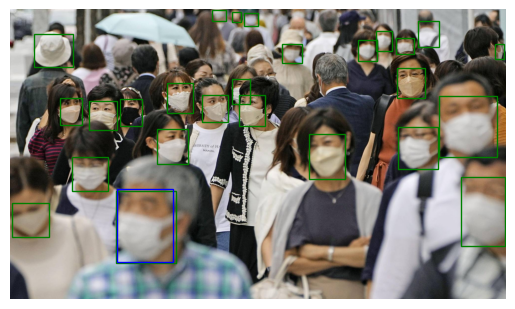

label tensor(1)
box tensor([353.7419, 198.1796, 438.9125, 303.9532], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([838.8436, 195.3627, 896.9742, 267.0658], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([502.3082, 210.1438, 572.6534, 291.9014], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([674.9747, 123.4160, 727.3843, 183.7696], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([724.4710, 162.4336, 781.4468, 226.4151], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([119.9658, 107.7617, 271.6138, 277.9014], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([903.4774, 216.8843, 938.5975, 256.0687], grad_fn=<UnbindBackward0>)
label tensor(2)
box tensor([902.7870, 215.1942, 939.1336, 255.1032], grad_fn=<UnbindBackward0>)


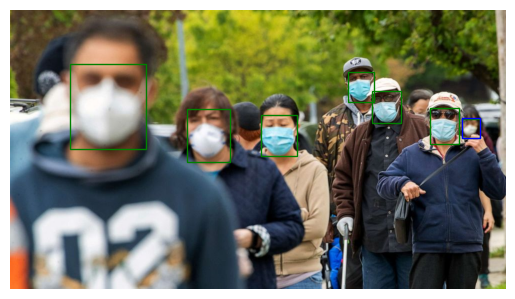

label tensor(1)
box tensor([ 41.4987, 144.3818,  75.3401, 180.5133], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([577.0557, 137.9656, 611.7708, 173.8030], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([290.5521, 125.0252, 327.4496, 160.7050], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([482.1623, 187.2852, 511.4942, 215.4640], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([329.3702, 112.9466, 345.9305, 138.7547], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([508.7031, 128.1785, 529.3575, 152.2872], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([225.1253, 138.3148, 259.2679, 174.7779], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([478.3374, 129.4173, 502.1426, 157.3007], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([137.4432, 148.8461, 179.4811, 187.7638], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([414.7515, 135.1460, 429.0232, 153.4080], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([693.5436, 15

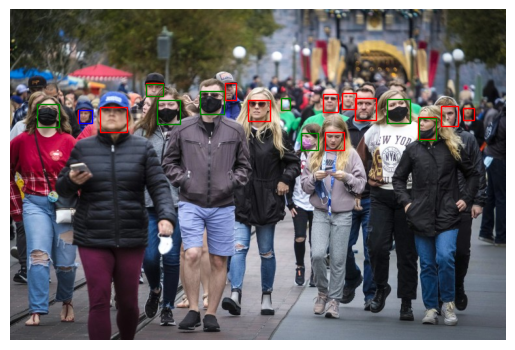

label tensor(1)
box tensor([ 3.6677, 47.0001, 23.0696, 84.8197], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([165.1946, 190.2607, 211.5527, 281.3977], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([ 69.3065,  92.1280,  87.7503, 129.0101], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([ 17.8275,  99.9251,  37.0826, 137.0987], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([ 67.3434,  83.4949,  86.0413, 108.1385], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([ 99.2620, 138.4169, 115.5353, 174.5934], grad_fn=<UnbindBackward0>)


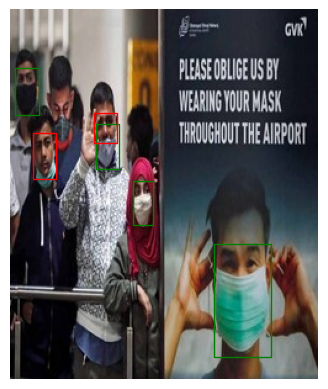

label tensor(1)
box tensor([665.4042,  81.4309, 723.8145, 153.3758], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([886.3511, 171.1621, 963.9535, 253.2452], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([490.1750, 211.8784, 592.1278, 337.1426], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([692.5973, 360.2474, 836.3990, 527.7469], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([154.6116,  93.3567, 208.0260, 153.2704], grad_fn=<UnbindBackward0>)
label tensor(1)
box tensor([327.9708, 134.9366, 405.5852, 244.7176], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([181.2740, 187.0284, 295.3137, 288.9383], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([ 948.8489,  325.8362, 1067.8928,  560.1382], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([263.2082,  49.6426, 315.7814,  94.5459], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([1012.8251,  120.6798, 1080.0000,  210.9260], grad_fn=<UnbindBackward0>)
label tensor(3)
box tensor([ 29.

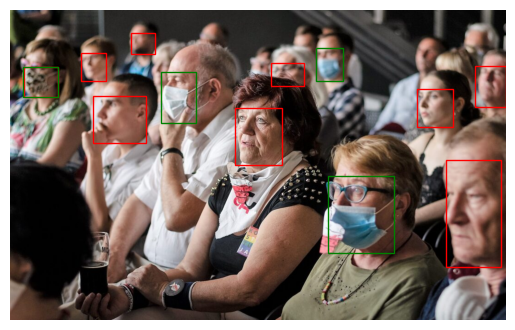

In [ ]:
print("Prediction")
for i in batches:
  pred = model2(i)
  plot_image(i[0], pred[0])